In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from numba import jit, prange, njit
import networkx as nx
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from scipy import optimize, stats
import math

## Compute the change of energy after flipping the k-th spin


The energy of this model is defined as follows:

$$ E = - \frac{1}{\lambda} log \left( \sum_{\mu = 1}^{P} exp( \lambda \xi^\mu \cdot x) \right), $$
where the factor $ \xi^\mu \cdot x $ is the overlap between the $\mu$-th original pattern and the configuration x. <br>

Now, if we change the sign of the $k$-th spin, we obtain that the overlap variation is:
$$  
\Delta overlap = overlap_{fin} - overlap_{in} = \left(\sum_{i \neq k}\xi_i^\mu x_i + \xi_k^\mu (-x_k)\right) - \left(\sum_{i \neq k}\xi_i^\mu x_i + \xi_k^\mu x_k\right)\\
= -2\xi_{k}^{\mu}x_k  $$.

Thus, the variation in the energy can be calculated as:
$$ E_f - E_i = - \frac{1}{\lambda} log \left( \sum_{\mu = 1}^{P} exp( \lambda \cdot overlap_{in}^\mu) \right)
+ \frac{1}{\lambda} log \left( \sum_{\mu = 1}^{P} exp( \lambda \cdot overlap_{fin}^\mu) \right)\\
= - \frac{1}{\lambda} \left[log \left(\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{fin}^\mu \right)
- log \left(\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{in}^\mu \right)\right]\\
= -\frac{1}{\lambda} \left[ log \left( \frac{\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{fin}^\mu)}{\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{in}^\mu)} \right) \right].
$$
We have that:
$$ overlap_{fin}^\mu = overlap_{in}^\mu - 2\xi_{k}^{\mu}x_k. $$
Thus:
$$\Delta E =  -\frac{1}{\lambda} \left[ log \left( \frac{\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{in}^\mu-2\lambda\xi_{k}^{\mu}x_k) }{\sum_{\mu = 1}^{P} exp(\lambda \cdot overlap_{in}^\mu)} \right) \right] $$

In [2]:
@jit(nopython = True)
def init_pattern(N, binary = True):
    '''
    Returns a binary pattern 
    
    INPUTs:
    -size of the pattern
    OUTPUTs:
    -pattern of size N
    '''
    pattern = np.random.choice(np.array([-1,1]), N)
    return pattern

In [3]:
def plot_pattern(pattern):
    '''
    Plot a lattice
    '''
    fig = plt.figure(figsize = (8, 3))
    N = len(pattern)
    G = nx.grid_2d_graph(N, 1)
    pos = dict( (n, n) for n in G.nodes() )
    colors = np.full(N, ["black"])

    for i in range(N):
        if pattern[i] == -1: colors[i] = "red"

    legend_elements = [Line2D([0], [0], marker = "s", color="w",label="Scatter",
                                 markerfacecolor = "black", markersize = 14),
                           Line2D([0], [0], marker="s", color="w", label="Scatter",
                                  markerfacecolor= "red", markersize=14)]
    nx.draw_networkx(G, pos = pos, with_labels = False, labels = None,
                         node_color = colors, node_size = 100, node_shape = "s")
    #plt.title("Example of initial state", weight = "bold", size = 16)
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.legend(legend_elements, ["+1", "-1"], bbox_to_anchor=(1, 1), loc="upper right", fontsize = 10)
    plt.show()
    #fig.savefig("presentazione/Images/CP_init_loc.pdf", transparent=True, bbox_inches = 'tight',
    #pad_inches = 0)
    return

In [4]:
@jit(nopython = True)
def multiple_patterns(n_patterns, pattern_size):
    '''
    Returns M binary patterns of size N
    
    Inputs:
    -M, the number of patterns
    -N, the size of each pattern
    
    Output:
    -A matrix containing one pattern per row
    '''
    a_c = 2**(pattern_size/2)
    
    if n_patterns <= math.floor(pattern_size*a_c):
        patterns = np.full((n_patterns, pattern_size), 0)
        for j in prange(n_patterns): patterns[j] = init_pattern(pattern_size)
        return patterns
    else: print("Impossible to store all the patterns")

In [5]:
@jit(nopython = True)
def overlap(pattern1, pattern2):
    return np.sum(pattern1*pattern2)

In [6]:
@jit(nopython = True)
def energy(pattern, original_patterns, lam = 0.01, binary = True):
    
    M = original_patterns.shape[0]
    
    energy = 0
    for m in range(M):
        #print(overlap(pattern, original_patterns[m]))
        energy += np.exp( lam * overlap(pattern, original_patterns[m]) )
        #print(energy)
    return (-1.)*np.log(energy)/lam

In [7]:
@jit(nopython = True)
def corruption(pattern, q):
    '''
    Corrupt each bit of a pattern with probability q
    
    Inputs:
    -the pattern we want to corrupt;
    -the probability of corruption
    
    Output:
    -the corrupted pattern
    '''
    
    N = len(pattern)
    corrupted_pattern = np.copy(pattern)
    for i in prange(N):
        if np.random.random() < q: corrupted_pattern[i] *= -1
    
    return corrupted_pattern

In [25]:
@jit(nopython = True)
def glauber1(pattern, original_patterns, lam, beta = 10):

    N = len(pattern)
    M = original_patterns.shape[0]
    #pattern_copy = pattern.copy()

    for n in range(N):
        #choose a random neuron index of the pattern
        i = np.random.randint(N)

        #deltaE = 0
        
        num, den = 0, 0
        for m in range(M):
            orig_p = original_patterns[m]
            overlap_in = overlap(orig_p, pattern)
            num += np.exp( lam * overlap_in - 2 * lam * orig_p[i] * pattern[i])
            den += np.exp( lam * overlap_in )
        
        deltaE = (-1.)/lam * np.log(num/den)
        #print(deltaE)
        
        if deltaE < 0 or np.random.random() < np.exp(- beta * deltaE):
            print("ciao")
            pattern[i] = -1. * pattern[i]

    return pattern

In [26]:
N = 20 #size of patterns
M = 10#number of patterns we want to store
q = 0.1 #probability of corruption

patterns = multiple_patterns(M, N) #create M patterns of length N

#corrupt the patterns
corrupted_patterns = np.full((M, N), 0)
for j in range(0, M): corrupted_patterns[j] = corruption(patterns[j], q)

In [27]:
%%time
nsteps = 10 #number of steps for the Monte Carlo algorithm

overlaps = np.ones(nsteps+1)
overlaps[0] = overlap(corrupted_patterns[0], patterns[0])
curr_p = corrupted_patterns[0].copy()
for s in range(1, nsteps+1):
    curr_p = glauber1(curr_p, patterns, lam = 0.001, beta = 100)
    overlaps[s] = overlap(curr_p, patterns[0])
    if overlaps[s] == 1: break
        

ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
ciao
CPU times: user 626 ms, sys: 21 ms, total: 647 ms
Wall time: 716 ms


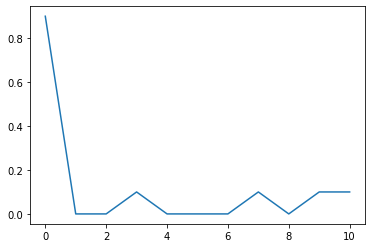

In [28]:
plt.plot(overlaps/N)

In [50]:
energy(corrupted_patterns[1], patterns)

-33.62922598654068

In [52]:
energy(patterns[1], patterns)

-32.96458961371307

In [20]:
M = 10
N = 10
patterns = multiple_patterns(M, N)
pattern1 = patterns[0].copy()
energy(patterns[0], patterns)

-230.0108129081762

In [21]:
pattern1[0]*=-1

In [22]:
energy(pattern1, patterns) - energy(patterns[0], patterns)

-0.7551866149185003

In [23]:
num, den = 0, 0
lam = 0.01
for m in range(M):
    orig_p = patterns[m]
    overlap_in = overlap(orig_p, patterns[0])
    num += np.exp( lam * overlap_in - 2 * lam * orig_p[0] * patterns[0][0])
    den += np.exp( lam * overlap_in )

deltaE = (-1.)/lam * np.log(num/den)

In [24]:
deltaE

-0.7551866149185186